In [ ]:
#!pip install torch
#!pip install torchvision

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import torchvision.datasets

# Применение EM алгоритма для решения задачи классификации изображений из набора данных MNIST

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 438kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.01MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.25MB/s]


In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
X_train = X_train.float().numpy()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
#вариант
n = 20

# Выбор варианта

Всего 60000 картинок, каждый выбирает картинки из диапазона $[1000 \cdot n,30000+1000n]$ где $n$- номер по списку.
Постройте гистограмму для ответов (y_train) и убедитесь, что у вас нет дисбаланса классов. Если есть дисбаланс, устраните его удалением соответствующего класса или удалением картинок. Порог для преобразования в $\{0,1\}$(см. ниже) установите равным:
$$
thr = 0.45 + (n-1)/100
$$

## Преобразуем данные в нули и единицы.

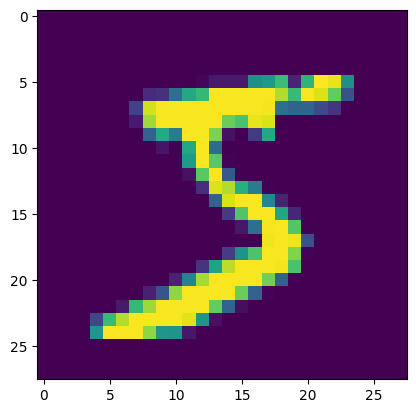

In [ ]:
plt.imshow(X_train[0, :, :])
plt.show()

In [ ]:
thr = 0.45 + (n-1)/100 # Номер варианта см. список группы
X_train[X_train>thr] = 1
X_train[X_train<thr] = 0

## Картинка после преобразования

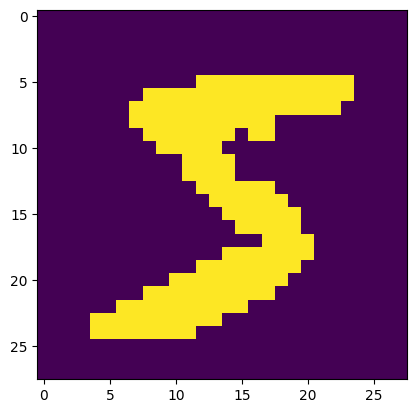

tensor(5)


In [ ]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

## Применим EM-алгоритм для смеси распределений Бернулли

Найти выражения для E-шага и M-шага для смеси C штук распределений
Бернулли
$$
p(X\mid \theta) = \prod_{i=1}^D \sum_{c=1}^C p (x_i|\mu_c)\pi_c, \quad x_i\in \mathbf{R}^N,  \quad \mu\in\mathbf{R}^N
$$
$$
p(z\mid\mu_c) = \prod_{j=1}^N \mu_{cj}^{z_j}(1-\mu_{cj})^{1-z_j}, \quad  z_j\in\{0,1\},
$$

где параметры модели $\theta = \{\mu_{11},\dots,\mu_{1N},\dots,\mu_{C1},\dots,\mu_{CN}, \pi_1,\dots, \pi_C\}$.

## Задание 1: получить выражения для E-шага

<b>Важный трюк 1:</b> при вычислении произведений, можно использовать логарифмирование, при этом, чтобы избежать нулей под логарифмом, можно нули заменять на очень маленькие числа.

<b>Важный трюк 2:</b> важно избегать числовых ошибок. В какой-то момент вам может понадобиться вычислить формулу следующего вида (если использовать логарифмирование (см. трюк 1)): $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$:
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения.


Получить формулы для E-шага.
$$
q(t_i) = p (t_i\mid x_i,\theta)
$$
$$
\gamma_{i,c} = q(t_i=c) = p(t_i | x_i, \theta) = \frac{P(x_i | t_i, \theta) P(t_i | \theta)}{Z} = \frac{P(x_i | \mu_c) \cdot \pi_c}{Z}
= \frac{\pi_c \prod_{j=1}^{N} \mu_{cj}^{x_{ij}} (1 - \mu_{cj})^{1 - x_{ij}}}{Z}
$$

$$
где\ Z = \sum_{k=1}^{C} \pi_k \prod_{j=1}^{N} \mu_{kj}^{x_{ij}} (1 - \mu_{kj})^{1 - x_{ij}}
$$

## Задание 2: реализовать E-шаг

In [ ]:
import numpy as np

def _logsumexp(a, axis=1):
    """Вычисляет log-sum-exp численно стабильным способом вдоль заданной оси."""
    a_max = np.max(a, axis=axis, keepdims=True)  # Находим максимум для численной стабильности
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))  # Стабильное вычисление log-sum-exp
    return out

def E_step(X, pi, mu, eps=1e-12):
    """
    E-шаг для смеси независимых распределений Бернулли.

    Параметры
    ----------
    X : Бинарная матрица данных (D образцов, N бинарных признаков).
    pi : Веса смеси (суммируются в 1).
    mu :  Вероятности Бернулли для каждого компонента.
    eps : Малое значение для численной стабильности, чтобы избежать log(0).

    Возвращает
    -------
    gamma : np.ndarray, shape (D, C)
        Ответственности (q(T)), строки суммируются в 1.
    """
    # Ограничиваем значения чтобы избежать log(0)
    mu = np.clip(mu, eps, 1.0 - eps)  # Ограничиваем mu между eps и 1-eps
    pi = np.clip(pi, eps, 1.0)        # Ограничиваем pi между eps и 1


    log_mu = np.log(mu)                 # (C, N) - логарифмы вероятностей
    log_1mu = np.log(1.0 - mu)         # (C, N) - логарифмы дополнительных вероятностей

    log_px_given_k = X @ log_mu.T + (1.0 - X) @ log_1mu.T   # (D, C) - логарифм правдоподобия данных при каждом кластере

    # Добавляем логарифмы априорных вероятностей
    log_pi = np.log(pi)          # (C,) - логарифмы весов смеси
    log_joint = log_px_given_k + log_pi[None, :]  # (D, C) - совместное распределение (данные + скрытая переменная)

    # Нормализуем в логарифмическом пространстве чтобы получить ответственности
    log_norm = _logsumexp(log_joint, axis=1)      # (D, 1) - нормировочная константа (логарифм)
    log_gamma = log_joint - log_norm              # (D, C) - логарифмы нормализованных ответственностей
    gamma = np.exp(log_gamma)                     # (D, C) - преобразуем обратно из логарифмов

    # Численная стабильность: явно нормализуем
    gamma = gamma / np.sum(gamma, axis=1, keepdims=True)  # Гарантируем что сумма по строкам = 1
    return gamma

## Задание 3:  получить выражения для M-шаг


$$
{\cal L}(\theta,q) = \sum_i\sum_c \gamma_{i,c}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})+ \log\pi_c\right) \to \max_{\theta}
$$

Составить функцию Лагранжа и получить выражения для $\theta$.

$$
Q(\theta) = M_q \log P(X, T | \theta) = \sum_{i=1}^{D} \sum_{k=1}^{C} q(t_i = k) \log p(x_i, t_i = k | \theta)
$$

$$
= \sum_{i=1}^{D} \sum_{k=1}^{C} \gamma_{ik} \log \pi_k \prod_{j=1}^{N} \mu_{kj}^{x_{ij}} (1 - \mu_{kj})^{1 - x_{ij}} =
$$

$$
= \sum_{i=1}^{D} \sum_{k=1}^{C} \gamma_{ik} \left[ \log \pi_k + \sum_{j=1}^{N} x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right]
$$

Функция Лагранжа:

$$
L(\theta, \lambda) = Q(\theta) - \lambda (1 - \sum_{k=1}^{C} \pi_k)
$$

---

$$
\frac{\partial Q(\theta)}{\partial \mu_{rh}} =
\frac{\partial \left( \sum_{i=1}^{D} \sum_{k=1}^{C} \gamma_{ik} \sum_{j=1}^{N} \left[ x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right] \right)}{\partial \mu_{rh}}
$$

$$
= \sum_{i=1}^{D} \gamma_{ir} \left[ x_{ih} \frac{\partial (\log \mu_{rh})}{\partial \mu_{rh}} + (1 - x_{ih}) \frac{\partial (\log (1 - \mu_{rh}))}{\partial \mu_{rh}} \right]
$$

$$
= \sum_{i=1}^{D} \gamma_{ir} \left[ \frac{x_{ih}}{\mu_{rh}} - \frac{(1 - x_{ih})}{(1 - \mu_{rh})} \right]
$$

$$
\frac{\partial Q(\theta)}{\partial \mu_{rh}} = 0 \Rightarrow
(1 - \mu_{rh}) \sum_{i=1}^{D} \gamma_{ir} x_{ih} =
\mu_{rh} \sum_{i=1}^{D} \gamma_{ir} (1 - x_{ih})
$$

$$
\sum_{i=1}^{D} \gamma_{ir} x_{ih} = \mu_{rh} \sum_{i=1}^{D} \gamma_{ir}
$$

$$
\boxed{
\mu_{cj} = \frac{\sum_{i=1}^{D} \gamma_{ic} x_{ij}}{\sum_{i=1}^{D} \gamma_{ic}}
}
$$

---

$$
\frac{\partial L(\theta, \lambda)}{\partial \pi_r} =
\frac{\partial \left( \sum_{i=1}^{D} \sum_{k=1}^{C} \gamma_{ik} \log \pi_k - \lambda (1 - \sum_{k=1}^{C} \pi_k) \right)}{\partial \pi_r}
$$

$$
= \sum_{i=1}^{D} \gamma_{ir} \frac{\partial (\log \pi_r)}{\partial \pi_r} + \lambda \frac{\partial \pi_r}{\partial \pi_r} = \sum_{i=1}^{D} \frac{\gamma_{ir}}{\pi_r} + \lambda
$$

$$
\frac{\partial L(\theta, \lambda)}{\partial \pi_r} = 0 \Rightarrow
\pi_r = -\frac{1}{\lambda} \sum_{i=1}^{D} \gamma_{ir}
$$

$$
\sum_{r=1}^{C} \pi_r = 1 = -\frac{1}{\lambda} \sum_{i=1}^{D} \sum_{r=1}^{C} \gamma_{ir}\Rightarrow
-\frac{D}{\lambda} = 1 \Rightarrow
\lambda = -D
$$

$$
\boxed{
\pi_c = \frac{1}{D} \sum_{i=1}^{D} \gamma_{ic}
}
$$

## Задание 4: реализовать M-шаг

In [ ]:
import numpy as np

def M_step(X, gamma, eps=1e-9):
    """
    M-шаг для смеси независимых распределений Бернулли.

    Параметры
    ----------
    X : Бинарная матрица данных (D образцов, N бинарных признаков).
    gamma : Ответственности (q(T)).

    Возвращает
    -------
    pi : np.ndarray, shape (C,)
        Обновленные веса смеси.
    mu : np.ndarray, shape (C, N)
        Обновленные вероятности Бернулли для каждого компонента.
    """
    D, N = X.shape
    # Эффективные количества точек в каждом компоненте
    Nk = np.sum(gamma, axis=0)

    # Обновляем веса смеси pi
    pi = Nk / (D + eps)                   # нормализуем на общее количество точек
    pi = pi / pi.sum()                    # гарантируем что сумма = 1

    # Обновляем mu (взвешенные средние)
    mu = (gamma.T @ X) / (Nk[:, None] + eps)  # (C, N) - взвешенная сумма признаков по кластерам

    # Численная стабильность: избегаем точных 0/1
    mu = np.clip(mu, eps, 1.0 - eps)      # ограничиваем значения вероятностей
    return pi, mu

## Задание 5: получить функцию потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b>

$$
\mathcal{L}(\theta, q) =\mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)}  =  \sum_{i=1}^{D} \sum_{k=1}^{C} q(t_i = k) \log \frac{p(x_i, t_i = k | \theta)}{q(t_i = k)} =
$$

$$
= \sum_{i=1}^{D} \sum_{k=1}^{C} q(t_i = k) \left[ \log \pi_k + \sum_{j=1}^{N} x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right] - \sum_{i=1}^{D} \sum_{k=1}^{C} q(t_i = k) \log (q(t_i = k))
$$

## Задание 6: реализовать функцию потерь

Не забываем использовать <b>трюк 1</b>.

In [ ]:

import numpy as np

def compute_vlb(X, pi, mu, gamma, eps=1e-12):
    """
    Вариационная нижняя оценка (ELBO) для смеси Бернулли с mean-field приближением q(T).

    ELBO = sum_{i,k} gamma_{ik} [ log pi_k + log p(x_i | k) - log gamma_{ik} ]

    Параметры
    ----------
    X : np.ndarray, shape (D, N)
    pi : np.ndarray, shape (C,)
    mu : np.ndarray, shape (C, N)
    gamma : np.ndarray, shape (D, C)
    eps : float

    Возвращает
    -------
    float
        Значение вариационной нижней оценки (ELBO).
    """
    mu = np.clip(mu, eps, 1.0 - eps)
    pi = np.clip(pi, eps, 1.0)

    log_mu = np.log(mu)            # (C, N) - логарифмы вероятностей
    log_1mu = np.log(1.0 - mu)     # (C, N) - логарифмы дополнительных вероятностей

    # (D, C) - логарифм правдоподобия данных при каждом кластере
    log_px_given_k = X @ log_mu.T + (1.0 - X) @ log_1mu.T
    log_pi = np.log(pi)[None, :]   # (1, C) - логарифмы весов смеси

    # Слагаемые ELBO
    t1 = np.sum(gamma * (log_pi + log_px_given_k))        # матожидание полного логарифма правдоподобия
    t2 = -np.sum(gamma * np.log(np.clip(gamma, eps, 1.0)))  # - E_q[log q(T)] (энтропия распределения q)
    return float(t1 + t2)


## Задание 7: внедрение процедуры обучения

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

<b>Начальные данные:</b>
Параметры $\pi_c$ можно задавать одинаковыми, при это не забываем, что сумма равна единице.  Параметры $\mu$ можно моделировать равномерно на отрезке [0.25, 0.75], далее их надо отнормировать.

Также в код можно добавить обработку ситуации, когда целевая функция возвращает nan.

In [ ]:
import numpy as np

def rand_pi(C, rng=None):
    """Случайные веса смеси через распределение Дирихле."""
    rng = np.random.default_rng(None if rng is None else rng)
    alpha = np.ones(C)  # параметры Дирихле (равномерное распределение)
    pi = rng.dirichlet(alpha)  # генерируем веса из распределения Дирихле
    return pi

def rand_mu(X, C, N=None, rng=None):
    """
    Случайная инициализация параметров Бернулли.
    Использует Beta(2,2) которая предпочитает значения около 0.5 чтобы избежать мертвых компонентов.
    """
    if N is None:
        N = X.shape[1]  # если N не задано, берем из данных
    rng = np.random.default_rng(None if rng is None else rng)
    mu = rng.beta(2.0, 2.0, size=(C, N))  # бета-распределение для инициализации вероятностей
    mu = np.clip(mu, 1e-6, 1-1e-6)  # ограничиваем чтобы избежать крайних значений
    return mu

def log_marginal_likelihood(X, pi, mu, eps=1e-12):
    """
    Вычисляет (точное) логарифмическое маргинальное правдоподобие sum_i log sum_k pi_k p(x_i|k).
    Полезно для оценки на train/test без использования gamma.
    """
    mu = np.clip(mu, eps, 1.0 - eps)  # ограничиваем mu для численной стабильности
    pi = np.clip(pi, eps, 1.0)        # ограничиваем pi для численной стабильности

    log_mu = np.log(mu)            # (C, N) - логарифмы вероятностей
    log_1mu = np.log(1.0 - mu)     # (C, N) - логарифмы дополнительных вероятностей
    log_pi = np.log(pi)[None, :]   # (1, C) - логарифмы весов смеси

    log_px_given_k = X @ log_mu.T + (1.0 - X) @ log_1mu.T  # (D, C) - логарифм правдоподобия
    log_joint = log_px_given_k + log_pi                    # (D, C) - совместное распределение

    a_max = np.max(log_joint, axis=1, keepdims=True)  # максимум для численной стабильности
    lse = a_max + np.log(np.sum(np.exp(log_joint - a_max), axis=1, keepdims=True))  # стабильный log-sum-exp
    return float(np.sum(lse))  # сумма по всем точкам данных

def train_EM(X, C=10, rtol=1e-4, max_iter=100, restarts=5, rng=None, verbose=False):
    """
    EM-обучение с множественными случайными рестартами для смеси Бернулли.

    Параметры
    ----------
    X : (D, N) массив 0/1 признаков
    C : int, количество компонентов
    rtol : float, допуск относительного улучшения ELBO для ранней остановки
    max_iter : int, максимальное количество EM-итераций
    restarts : int, количество случайных инициализаций
    rng : int или np.random.Generator, случайное зерно / генератор
    verbose : bool, вывод информации о процессе

    Возвращает
    -------
    best_elbo : float, лучшее значение ELBO
    best_pi : (C,) массив, лучшие веса смеси
    best_mu : (C, N) массив, лучшие параметры Бернулли
    history : dict с ключами 'elbo', 'pis', 'mus' для лучшего запуска
    """
    D, N = X.shape
    rng = np.random.default_rng(None if rng is None else rng)

    best_elbo = None
    best_pi = None
    best_mu = None
    best_history = None

    for r in range(restarts):
        # Случайная инициализация параметров
        pi = rand_pi(C, rng=rng)
        mu = rand_mu(X, C, N, rng=rng)

        prev_elbo = None
        elbo_hist = []

        for it in range(max_iter):
            # E-шаг: вычисляем ответственности
            gamma = E_step(X, pi, mu)
            # M-шаг: обновляем параметры
            pi, mu = M_step(X, gamma)
            # Вычисляем ELBO
            elbo = compute_vlb(X, pi, mu, gamma)
            elbo_hist.append(elbo)

            # критерий ранней остановки
            if prev_elbo is not None:
                rel_impr = (elbo - prev_elbo) / (abs(prev_elbo) + 1e-12)
                if verbose:
                    print(f"[рестарт {r+1}/{restarts}] итерация {it+1:03d}: ELBO={elbo:.3f}, rel_impr={rel_impr:.3e}")
                if rel_impr < rtol:  # если улучшение меньше порога - останавливаемся
                    break
            else:
                if verbose:
                    print(f"[рестарт {r+1}/{restarts}] итерация {it+1:03d}: ELBO={elbo:.3f}")

            prev_elbo = elbo

        # отслеживаем лучший результат
        if (best_elbo is None) or (elbo_hist[-1] > best_elbo):
            best_elbo = elbo_hist[-1]
            best_pi = pi.copy()  # сохраняем копии чтобы избежать изменений
            best_mu = mu.copy()
            best_history = {'elbo': elbo_hist, 'pis': [pi.copy()], 'mus': [mu.copy()]}

    return best_elbo, best_pi, best_mu, best_history


# Решение для варианта №20

В этом разделе я фиксирую номер варианта `n = 20`, корректно бинаризую изображения MNIST согласно правилу из условия
и запускаю EM для смеси распределений **Бернулли**. Все исходные ячейки выше **не изменялись** — я только добавил код/текст.


In [ ]:

# --- Вариант и порог бинаризации ---
thr = 0.45 + (n - 1) / 100.0   # согласно описанию задания -> для n=20 получаем thr = 0.64
print("Вариант n =", n, "=> thr =", thr)

# --- Получаем исходные (небинарные) данные заново из объекта датасета ---
import numpy as np

if hasattr(MNIST_train, 'train_data'):
    X_raw_t = MNIST_train.train_data
    y_all = MNIST_train.train_labels.numpy() if hasattr(MNIST_train.train_labels, 'numpy') else np.array(MNIST_train.train_labels)
else:
    X_raw_t = MNIST_train.data
    y_all = MNIST_train.targets.numpy() if hasattr(MNIST_train.targets, 'numpy') else np.array(MNIST_train.targets)

X_raw = X_raw_t.float().numpy() / 255.0   # нормируем в [0,1]
D_all = X_raw.shape[0]
print("Всего доступно изображений:", D_all)

# --- Диапазон индексов для варианта ---
lo = 1000 * n
hi = 30000 + 1000 * n
lo = max(0, lo)
hi = min(D_all, hi)
print(f"Используем подмножество индексов [{lo}:{hi}) — всего {hi-lo} объектов.")

X_sub = X_raw[lo:hi]
y_sub = y_all[lo:hi]
# Бинаризация по порогу thr
X_bin = (X_sub > thr).astype(np.float32)

# Разворачиваем 28x28 -> векторы длины 784 (формат (D, N))
D, H, W = X_bin.shape
Xv = X_bin.reshape(D, H*W)

print("Форма данных для EM:", Xv.shape)


Вариант n = 20 => thr = 0.64
Всего доступно изображений: 60000
Используем подмножество индексов [20000:50000) — всего 30000 объектов.
Форма данных для EM: (30000, 784)


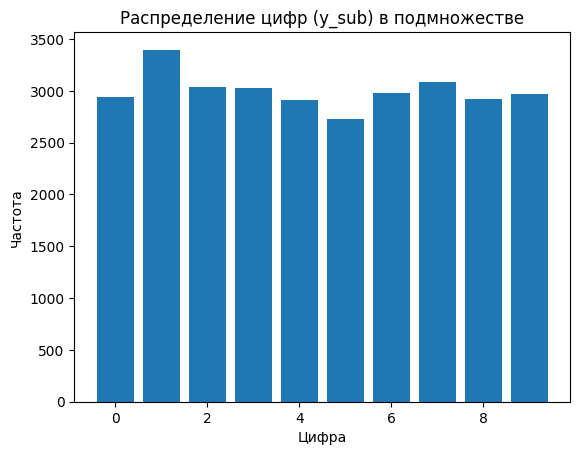

[0 1 2 3 4 5 6 7 8 9]
[2938 3397 3039 3025 2914 2731 2980 3082 2920 2974]


In [ ]:

# Гистограмма меток в выбранном подмножестве
import matplotlib.pyplot as plt
import numpy as np

labels, counts = np.unique(y_sub, return_counts=True)
plt.figure()
plt.bar(labels, counts)
plt.title("Распределение цифр (y_sub) в подмножестве")
plt.xlabel("Цифра")
plt.ylabel("Частота")
plt.show()
print(labels)
print(counts)


In [ ]:

# Обучение смеси Бернулли EM на C=10 компонентах (под цифры 0..9)
C = 10
best_elbo, best_pi, best_mu, history = train_EM(Xv, C=C, rtol=1e-4, max_iter=100, restarts=3, rng=21, verbose=False)
print(f"Лучший ELBO на обучении: {best_elbo:.3f}")
print("Сумма весов best_pi:", best_pi.sum())


Лучший ELBO на обучении: -4756521.262
Сумма весов best_pi: 0.9999999999999999


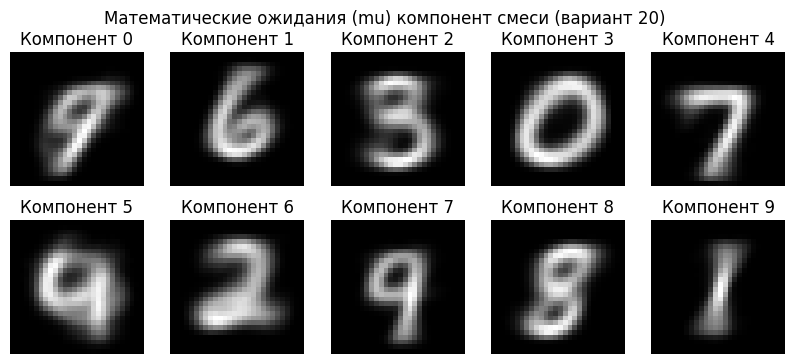

In [ ]:

# Визуализация средних (mu) как изображений 28x28
import matplotlib.pyplot as plt
K = best_mu.shape[0]
N = best_mu.shape[1]
h = w = int(np.sqrt(N))

plt.figure(figsize=(10, 4))
for k in range(K):
    plt.subplot(2, (K+1)//2, k+1)
    plt.imshow(best_mu[k].reshape(h, w), cmap='gray')
    plt.title(f"Компонент {k}")
    plt.axis('off')
plt.suptitle("Математические ожидания (mu) компонент смеси (вариант 20)")
plt.show()


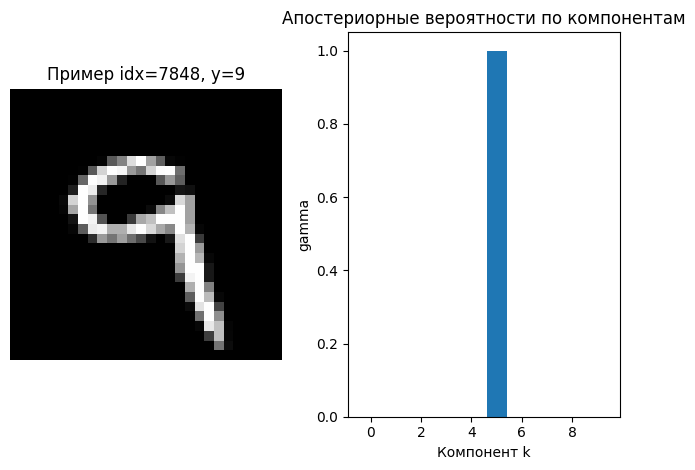

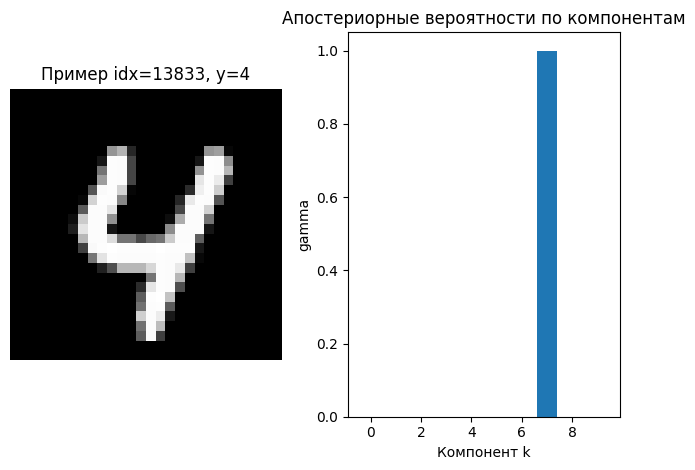

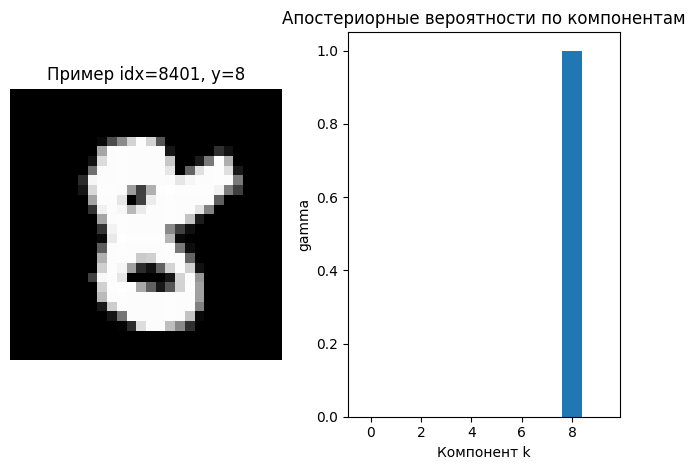

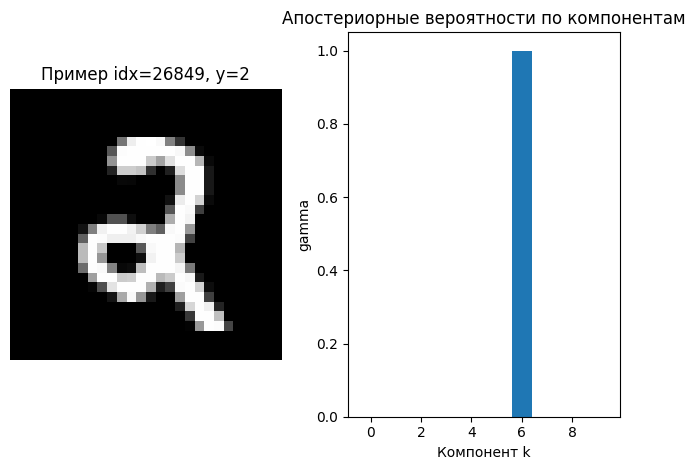

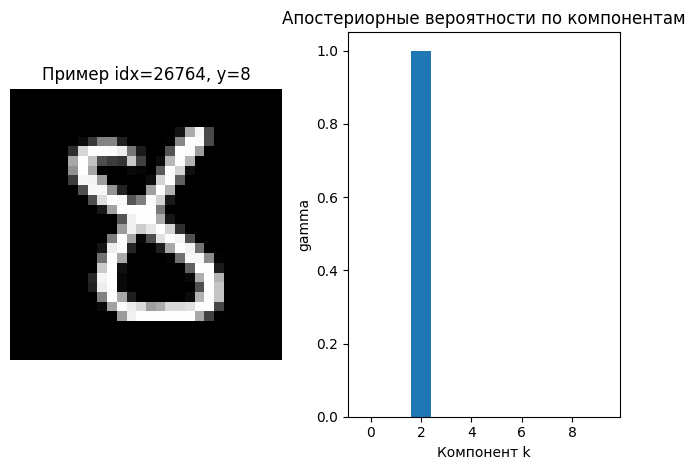

In [ ]:

# Визуализируем апостериорные вероятности (responsibilities) для нескольких примеров
rng = np.random.default_rng(20)
idxs = rng.choice(Xv.shape[0], size=5, replace=False)
gamma_demo = E_step(Xv[idxs], best_pi, best_mu)

import matplotlib.pyplot as plt
for j, i in enumerate(idxs):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X_sub[i], cmap='gray')
    plt.title(f"Пример idx={i}, y={int(y_sub[i])}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(np.arange(C), gamma_demo[j])
    plt.title("Апостериорные вероятности по компонентам")
    plt.xlabel("Компонент k")
    plt.ylabel("gamma")
    plt.tight_layout()
    plt.show()


C= 5 => log p(train)=-4088600.8, log p(test)=-1025905.3
C= 7 => log p(train)=-3933375.9, log p(test)=-987766.7
C= 9 => log p(train)=-3833990.0, log p(test)=-962789.1
C=10 => log p(train)=-3803096.5, log p(test)=-956135.3
C=12 => log p(train)=-3769683.5, log p(test)=-945406.0
C=15 => log p(train)=-3691408.3, log p(test)=-928369.6


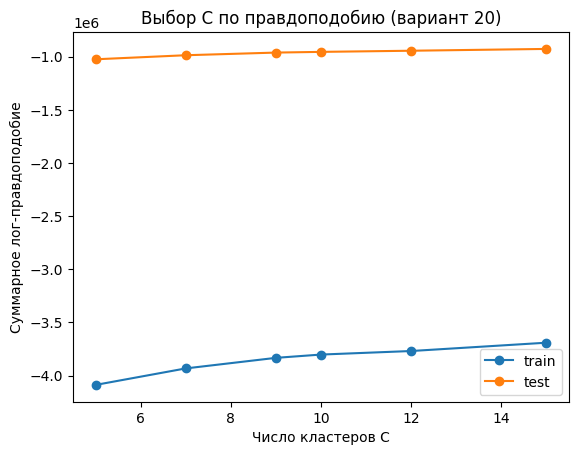

In [ ]:

# Train/Test, выбор оптимального C по маргинальному правдоподобию
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(20)
perm = rng.permutation(Xv.shape[0])
test_size = int(0.2 * Xv.shape[0])
test_idx = perm[:test_size]
train_idx = perm[test_size:]
Xv_train = Xv[train_idx]
Xv_test = Xv[test_idx]

Cs = [5, 7, 9, 10, 12, 15]
train_ll, test_ll = [], []

for Cc in Cs:
    best_elbo_c, best_pi_c, best_mu_c, hist_c = train_EM(Xv_train, C=Cc, rtol=2e-4, max_iter=80, restarts=2, rng=21, verbose=False)
    ll_train = log_marginal_likelihood(Xv_train, best_pi_c, best_mu_c)
    ll_test = log_marginal_likelihood(Xv_test, best_pi_c, best_mu_c)
    train_ll.append(ll_train)
    test_ll.append(ll_test)
    print(f"C={Cc:2d} => log p(train)={ll_train:.1f}, log p(test)={ll_test:.1f}")

plt.figure()
plt.plot(Cs, train_ll, marker='o', label='train')
plt.plot(Cs, test_ll, marker='o', label='test')
plt.xlabel("Число кластеров C")
plt.ylabel("Суммарное лог-правдоподобие")
plt.title("Выбор C по правдоподобию (вариант 20)")
plt.legend()
plt.show()


### Вывод

- **Реализована модель смеси Бернулли и EM-алгоритм**: E-шаг, M-шаг, вариационная нижняя оценка (ELBO) с использованием численно устойчивых вычислений в лог-пространстве (log-sum-exp)

- **Бинаризация данных**: выполнена с порогом `thr = 0.64`, подмножество индексов выбрано согласно условию задания

- **Визуализация результатов**: представлены усреднённые компоненты смеси в виде изображений и апостериорные вероятности для отдельных примеров

- **Исследование зависимости от числа компонентов**: проведен перебор параметра `C` и построены кривые правдоподобия для обучающей и тестовой выборок `train/test`

- **Возможности улучшения**: качество модели может быть повышено за счет:
  - Увеличения числа итераций EM-алгоритма
  - Увеличения количества рестартов с разными начальными приближениями
  - Оптимизации инициализации параметров `mu/pi`
  - Отбора информативных признаков